In [2]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


np.random.seed(seed)
tf.random.set_seed(seed)

1 Physical GPUs, 1 Logical GPUs


## Cyclic Stocks

### Singapore Airlines

In [7]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_7   willr_7     OBV_7  labels
0  2000-01-12     0.898039  0.958972  0.604167  0.653426     2.0
1  2000-01-13     0.960784  0.965065  0.770834  0.672066     2.0
2  2000-01-14     0.952941  0.967502  0.878049  0.663181     2.0
3  2000-01-17     0.952941  0.969329  0.791667  0.663181     2.0
4  2000-01-18     0.905882  0.957906  0.352941  0.657046     2.0


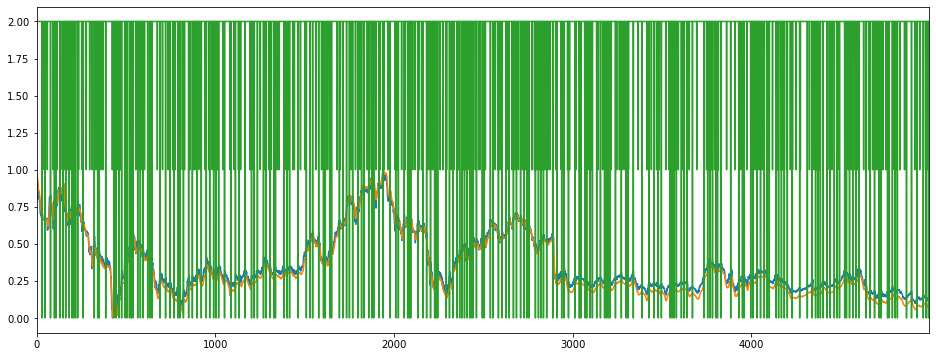

In [8]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [9]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels
Date,,,,,
2000-01-12,0.898039,0.958972,0.604167,0.653426,2.0
2000-01-13,0.960784,0.965065,0.770834,0.672066,2.0
2000-01-14,0.952941,0.967502,0.878049,0.663181,2.0
2000-01-17,0.952941,0.969329,0.791667,0.663181,2.0
2000-01-18,0.905882,0.957906,0.352941,0.657046,2.0


In [10]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        for j in range(1,114):
            x = np.zeros(128)
            data_15.append(x)
        labels.append(i[-1])
        sequential.append(data_15)
        data_15 = data_15[1:15]
    else:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        count+= 1

In [11]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(24)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         for j in range(1,14):
#             x = np.zeros(28)
#             data_15.append(x)
#         labels.append(i[-1])
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(24)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [12]:
X = np.array(sequential).reshape(-1, 128, 128, 1)
y = labels
y = np.array(y)

In [13]:
X.shape

(4984, 128, 128, 1)

In [14]:
v = X.reshape(X.shape[0],128, 128)
v[0]

array([[0.89803913, 0.95897235, 0.60416668, ..., 0.        , 0.        ,
        0.        ],
       [0.96078432, 0.96506478, 0.77083361, ..., 0.        , 0.        ,
        0.        ],
       [0.95294115, 0.96750175, 0.87804879, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed)

In [79]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 300  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.3, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.2, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [81]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

#Scaling by total/3 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / sell)*(total)/3.0 
# weight_for_1 = (1 / buy)*(total)/3.0
# weight_for_2 = (1 / hold)*(total)/3.0

# d_class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.466292134831461, 1: 7.637931034482759, 2: 0.3656121045392022}
Epoch 1/300
32/32 [==============================] - 4s 127ms/step - loss: 0.2632 - accuracy: 0.1996 - val_loss: 0.2131 - val_accuracy: 0.0481
Epoch 2/300
32/32 [==============================] - 2s 65ms/step - loss: 0.2305 - accuracy: 0.2877 - val_loss: 0.1922 - val_accuracy: 0.4112
Epoch 3/300
32/32 [==============================] - 2s 72ms/step - loss: 0.2267 - accuracy: 0.3188 - val_loss: 0.1944 - val_accuracy: 0.0481
Epoch 4/300
32/32 [==============================] - 2s 67ms/step - loss: 0.2211 - accuracy: 0.2731 - val_loss: 0.1946 - val_accuracy: 0.1143
Epoch 5/300
32/32 [==============================] - 2s 64ms/step - loss: 0.2166 - accuracy: 0.2714 - val_loss: 0.1928 - val_accuracy: 0.1284
Epoch 6/300
32/32 [==============================] - 2s 70ms/step - loss: 0.2124 - accuracy: 0.2250 - val_loss: 0.1997 - val_accuracy: 0.0742
Epoch 7/300
32/32 [==============================] - 2s 66ms/step - loss: 0.206

32/32 [==============================] - 1s 40ms/step - loss: 0.1709 - accuracy: 0.2222 - val_loss: 0.2017 - val_accuracy: 0.1595
Epoch 57/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1691 - accuracy: 0.2245 - val_loss: 0.2021 - val_accuracy: 0.1535
Epoch 58/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1667 - accuracy: 0.2300 - val_loss: 0.2025 - val_accuracy: 0.1795
Epoch 59/300
32/32 [==============================] - 1s 39ms/step - loss: 0.1691 - accuracy: 0.2252 - val_loss: 0.2011 - val_accuracy: 0.1685
Epoch 60/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1685 - accuracy: 0.2144 - val_loss: 0.2013 - val_accuracy: 0.1675
Epoch 61/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1665 - accuracy: 0.2192 - val_loss: 0.2027 - val_accuracy: 0.1665
Epoch 62/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1672 - accuracy: 0.2054 - val_loss: 0.2025 - val_accuracy: 0.1655
Epoch 63/300

Epoch 170/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1329 - accuracy: 0.3394 - val_loss: 0.2080 - val_accuracy: 0.2798
Epoch 171/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1351 - accuracy: 0.3524 - val_loss: 0.2108 - val_accuracy: 0.2668
Epoch 172/300
32/32 [==============================] - 1s 39ms/step - loss: 0.1322 - accuracy: 0.3426 - val_loss: 0.2053 - val_accuracy: 0.2929
Epoch 173/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1350 - accuracy: 0.3336 - val_loss: 0.2113 - val_accuracy: 0.2538
Epoch 174/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1315 - accuracy: 0.3737 - val_loss: 0.2114 - val_accuracy: 0.2618
Epoch 175/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1313 - accuracy: 0.3662 - val_loss: 0.2073 - val_accuracy: 0.3039
Epoch 176/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1326 - accuracy: 0.3436 - val_loss: 0.2092 - val_accuracy:

Epoch 227/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1084 - accuracy: 0.5673 - val_loss: 0.1832 - val_accuracy: 0.5607
Epoch 228/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1054 - accuracy: 0.6152 - val_loss: 0.1934 - val_accuracy: 0.5316
Epoch 229/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1021 - accuracy: 0.6358 - val_loss: 0.1942 - val_accuracy: 0.5176
Epoch 230/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1040 - accuracy: 0.6260 - val_loss: 0.2088 - val_accuracy: 0.4945
Epoch 231/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1000 - accuracy: 0.6351 - val_loss: 0.2018 - val_accuracy: 0.5145
Epoch 232/300
32/32 [==============================] - 1s 41ms/step - loss: 0.1015 - accuracy: 0.6356 - val_loss: 0.1960 - val_accuracy: 0.5537
Epoch 233/300
32/32 [==============================] - 1s 40ms/step - loss: 0.1017 - accuracy: 0.6275 - val_loss: 0.1970 - val_accuracy:

Epoch 284/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0710 - accuracy: 0.7993 - val_loss: 0.1866 - val_accuracy: 0.6820
Epoch 285/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0688 - accuracy: 0.8116 - val_loss: 0.1811 - val_accuracy: 0.6901
Epoch 286/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0689 - accuracy: 0.8187 - val_loss: 0.1813 - val_accuracy: 0.6820
Epoch 287/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0760 - accuracy: 0.7861 - val_loss: 0.2434 - val_accuracy: 0.5547
Epoch 288/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0736 - accuracy: 0.7845 - val_loss: 0.1861 - val_accuracy: 0.6620
Epoch 289/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0854 - accuracy: 0.7331 - val_loss: 0.1675 - val_accuracy: 0.6881
Epoch 290/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0700 - accuracy: 0.8146 - val_loss: 0.1848 - val_accuracy:

In [82]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17077705264091492
Test accuracy: 0.7221664786338806


In [83]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.0963693  -3.4317029   0.44899788]
 [-3.090783   -0.86585534 -0.09166518]
 [-2.4079788  -1.6209297   0.38517982]
 ...
 [-3.1915176  -0.79414654 -0.20458919]
 [-3.5096228  -1.4344188   0.36722514]
 [-1.6197166  -3.802921    0.28574878]]


Counter({2: 791, 0: 138, 1: 68})

In [84]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 899, 1: 50, 0: 48})

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 997
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 43
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 40
actual holds but predicted buy: 60
actual holds but predicted sell: 131
actual predicted holds: 708
Percentage buys correct: 12.0%
Percentage sells correct: 12.5%
Percentage holds correct: 78.75417130144605%
actual buys: 50
actual sells: 48
actual holds: 899


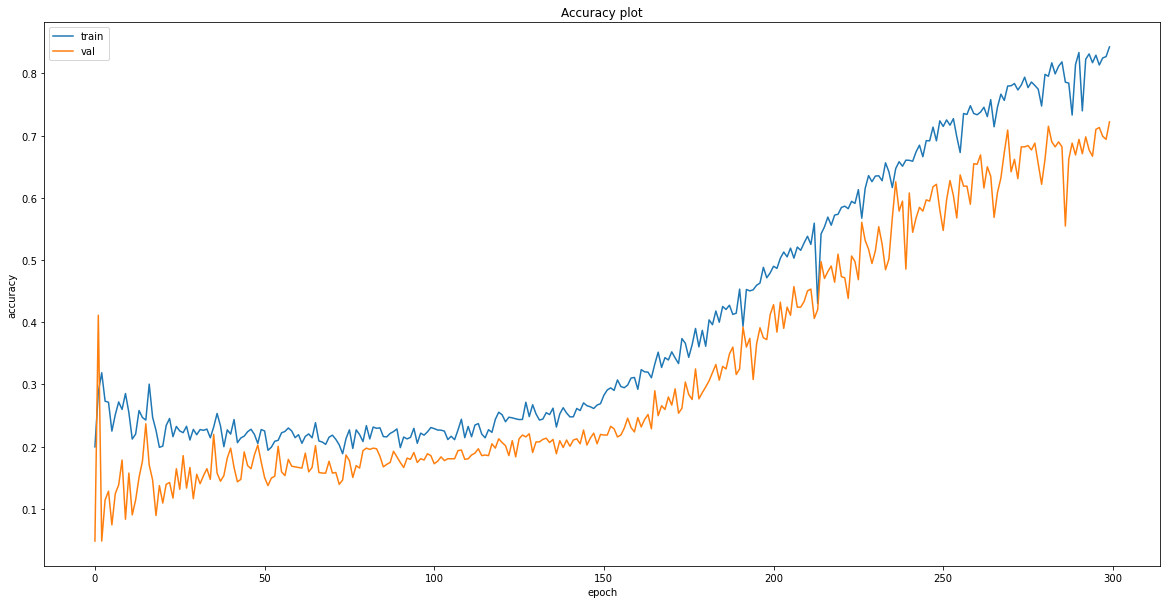

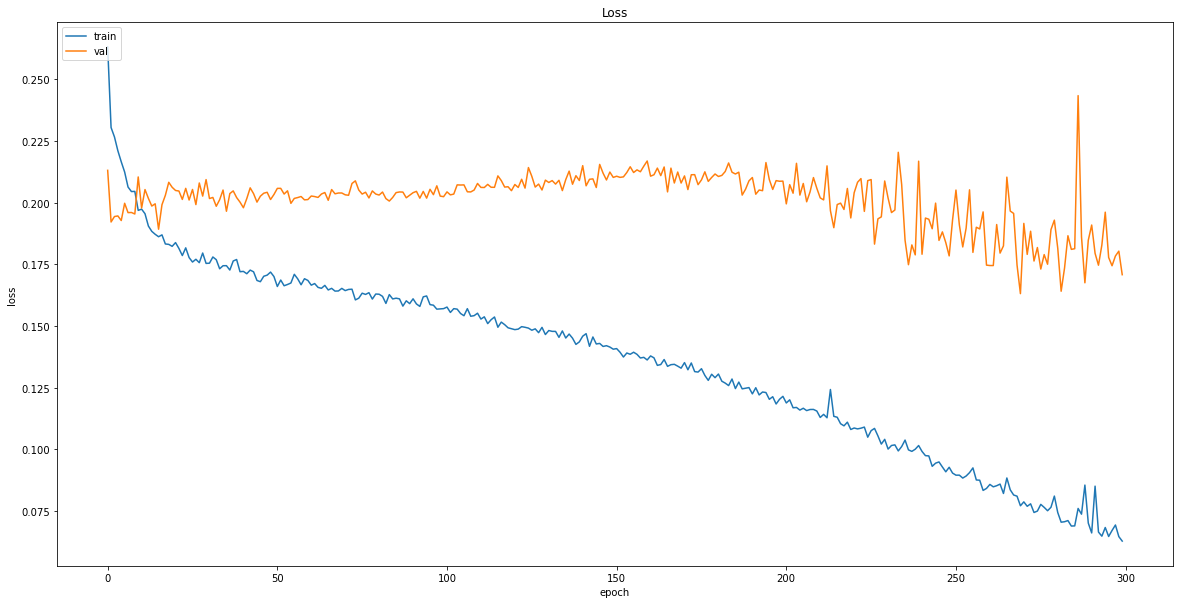

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model\assets


In [88]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/C6L.SI_data_test.csv")
print(df.head())

         Date  previous_1d     EMA_7   willr_7     OBV_7  labels
0  2020-01-13     0.982578  0.994988  0.413793  0.986813     2.0
1  2020-01-14     0.982578  0.993136  0.413793  0.986813     2.0
2  2020-01-15     0.993031  0.994429  0.947367  0.989625     2.0
3  2020-01-16     0.996516  0.996293  0.833333  0.993438     2.0
4  2020-01-17     0.998258  0.998138  0.807692  0.996138     0.0


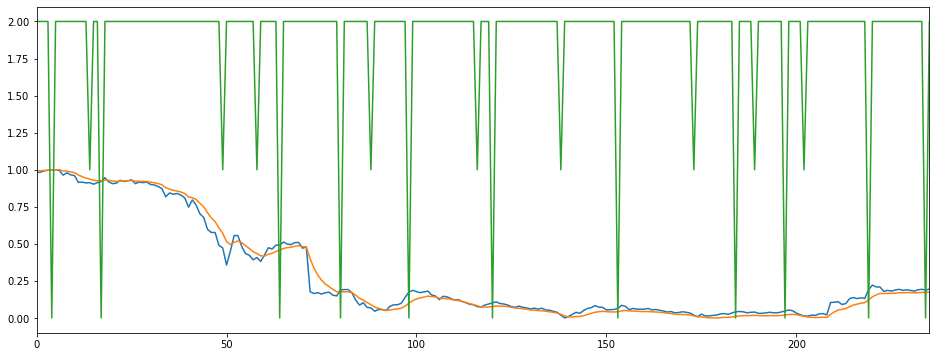

In [89]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [90]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels
Date,,,,,
2020-01-13,0.982578,0.994988,0.413793,0.986813,2.0
2020-01-14,0.982578,0.993136,0.413793,0.986813,2.0
2020-01-15,0.993031,0.994429,0.947367,0.989625,2.0
2020-01-16,0.996516,0.996293,0.833333,0.993438,2.0
2020-01-17,0.998258,0.998138,0.807692,0.996138,0.0


In [91]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        for j in range(1,114):
            x = np.zeros(128)
            data_15.append(x)
        labels.append(i[-1])
        sequential.append(data_15)
        data_15 = data_15[1:15]
    else:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        count+= 1

In [92]:
X = np.array(sequential).reshape(-1, 128, 128, 1)
y = labels
y = np.array(y)

In [93]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [94]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1478 - accuracy: 0.7613
Test loss: 0.14779002964496613
Test accuracy: 0.7612612843513489


In [95]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 17, 1: 25})

In [96]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [97]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_7   willr_7     OBV_7  labels
Date                                                         
2020-01-13     0.982578  0.994988  0.413793  0.986813     2.0
2020-01-14     0.982578  0.993136  0.413793  0.986813     2.0
2020-01-15     0.993031  0.994429  0.947367  0.989625     2.0
2020-01-16     0.996516  0.996293  0.833333  0.993438     2.0
2020-01-17     0.998258  0.998138  0.807692  0.996138     0.0


In [98]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-01-31,0.912892,0.943418,0.107144,0.971539,2.0,2,1
2020-02-03,0.902439,0.936580,0.125001,0.981836,1.0,2,2
2020-02-04,0.912892,0.928771,0.042552,0.971941,2.0,2,2
2020-02-05,0.919861,0.925595,0.216216,0.980027,2.0,2,0
2020-02-06,0.945993,0.925001,0.700002,0.988423,0.0,2,2


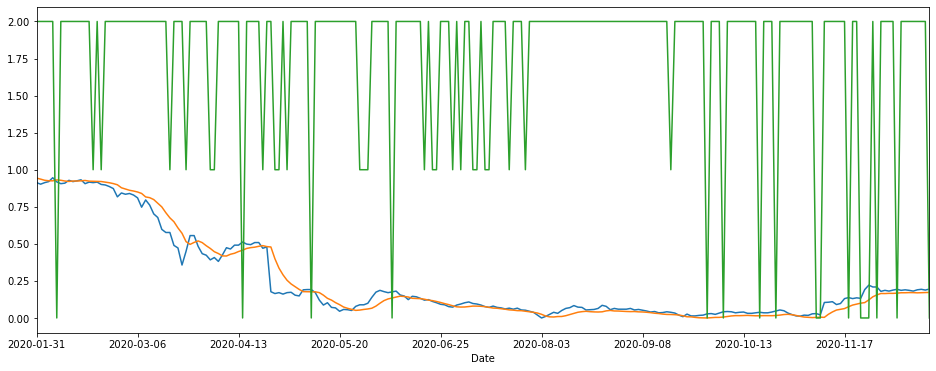

In [99]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

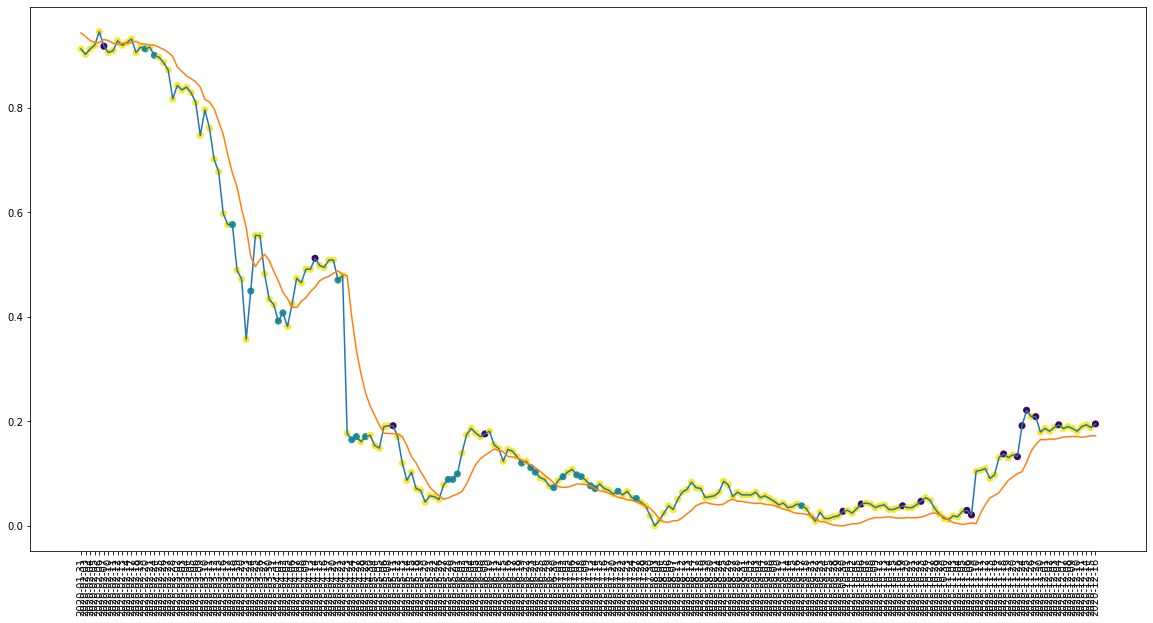

In [100]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_7'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [101]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 222
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 14
actual predicted holds: 165
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 30.0%
Percentage holds correct: 81.2807881773399%
actual buys: 9
actual sells: 10
actual holds: 203


### OCBC 

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/O39.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_7   willr_7     OBV_7  labels
0  2000-01-12     0.306698  0.319240  0.210526  0.215172     2.0
1  2000-01-13     0.321074  0.318171  0.411764  0.229018     2.0
2  2000-01-14     0.335451  0.321112  0.833333  0.245965     0.0
3  2000-01-17     0.340243  0.324565  0.916666  0.257913     2.0
4  2000-01-18     0.316282  0.320917  0.363637  0.250013     2.0


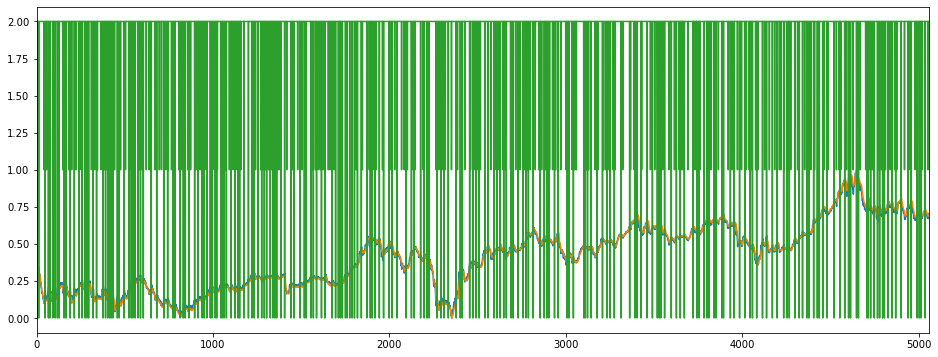

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels
Date,,,,,
2000-01-12,0.306698,0.319240,0.210526,0.215172,2.0
2000-01-13,0.321074,0.318171,0.411764,0.229018,2.0
2000-01-14,0.335451,0.321112,0.833333,0.245965,0.0
2000-01-17,0.340243,0.324565,0.916666,0.257913,2.0
2000-01-18,0.316282,0.320917,0.363637,0.250013,2.0


In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        for j in range(1,114):
            x = np.zeros(128)
            data_15.append(x)
        labels.append(i[-1])
        sequential.append(data_15)
        data_15 = data_15[1:15]
    else:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        count+= 1

In [9]:
X = np.array(sequential).reshape(-1, 128, 128, 1)
y = labels
y = np.array(y)

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed)

In [11]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 300  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [12]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.3, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.2, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

#Scaling by total/3 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / sell)*(total)/3.0 
# weight_for_1 = (1 / buy)*(total)/3.0
# weight_for_2 = (1 / hold)*(total)/3.0

# d_class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.43646408839779, 1: 7.91764705882353, 2: 0.3650664496880933}
Epoch 1/300
 1/32 [..............................] - ETA: 0s - loss: 0.3664 - accuracy: 0.2344WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
32/32 [==============================] - 3s 97ms/step - loss: 0.2655 - accuracy: 0.1981 - val_loss: 0.2272 - val_accuracy: 0.0485
Epoch 2/300
32/32 [==============================] - 2s 56ms/step - loss: 0.2263 - accuracy: 0.2776 - val_loss: 0.2026 - val_accuracy: 0.0485
Epoch 3/300
32/32 [==============================] - 2s 60ms/step - loss: 0.2207 - accuracy: 0.2838 - val_loss: 0.1909 - val_accuracy: 0.1099
Epoch 4/300
32/32 [==============================] - 2s 56ms/step - loss: 0.2167 - accuracy: 0.3403 - val_loss: 0.1967 - val_accuracy: 0

32/32 [==============================] - 2s 56ms/step - loss: 0.1669 - accuracy: 0.1904 - val_loss: 0.2067 - val_accuracy: 0.1267
Epoch 54/300
32/32 [==============================] - 2s 56ms/step - loss: 0.1654 - accuracy: 0.1798 - val_loss: 0.2024 - val_accuracy: 0.1297
Epoch 55/300
32/32 [==============================] - 2s 54ms/step - loss: 0.1639 - accuracy: 0.2001 - val_loss: 0.1993 - val_accuracy: 0.1505
Epoch 56/300
32/32 [==============================] - 2s 57ms/step - loss: 0.1634 - accuracy: 0.2058 - val_loss: 0.1978 - val_accuracy: 0.1624
Epoch 57/300
32/32 [==============================] - 2s 54ms/step - loss: 0.1658 - accuracy: 0.1748 - val_loss: 0.2050 - val_accuracy: 0.1188
Epoch 58/300
32/32 [==============================] - 2s 55ms/step - loss: 0.1619 - accuracy: 0.1823 - val_loss: 0.2035 - val_accuracy: 0.1426
Epoch 59/300
32/32 [==============================] - 2s 54ms/step - loss: 0.1615 - accuracy: 0.1991 - val_loss: 0.2064 - val_accuracy: 0.1416
Epoch 60/300

32/32 [==============================] - 2s 54ms/step - loss: 0.1503 - accuracy: 0.1912 - val_loss: 0.2052 - val_accuracy: 0.1624
Epoch 111/300
32/32 [==============================] - 2s 56ms/step - loss: 0.1507 - accuracy: 0.1969 - val_loss: 0.2052 - val_accuracy: 0.1703
Epoch 112/300
32/32 [==============================] - 2s 55ms/step - loss: 0.1508 - accuracy: 0.2088 - val_loss: 0.2099 - val_accuracy: 0.1743
Epoch 113/300
32/32 [==============================] - 2s 53ms/step - loss: 0.1517 - accuracy: 0.2150 - val_loss: 0.2059 - val_accuracy: 0.1752
Epoch 114/300
32/32 [==============================] - 2s 56ms/step - loss: 0.1512 - accuracy: 0.1914 - val_loss: 0.2049 - val_accuracy: 0.1703
Epoch 115/300
32/32 [==============================] - 2s 55ms/step - loss: 0.1500 - accuracy: 0.2016 - val_loss: 0.2051 - val_accuracy: 0.1653
Epoch 116/300
32/32 [==============================] - 2s 58ms/step - loss: 0.1492 - accuracy: 0.2060 - val_loss: 0.2075 - val_accuracy: 0.1604
Epoch 

Epoch 167/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1377 - accuracy: 0.2771 - val_loss: 0.2059 - val_accuracy: 0.2396
Epoch 168/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1369 - accuracy: 0.2850 - val_loss: 0.2044 - val_accuracy: 0.2495
Epoch 169/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1361 - accuracy: 0.2784 - val_loss: 0.2018 - val_accuracy: 0.2515
Epoch 170/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1356 - accuracy: 0.2870 - val_loss: 0.2054 - val_accuracy: 0.2564
Epoch 171/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1353 - accuracy: 0.3016 - val_loss: 0.2041 - val_accuracy: 0.2574
Epoch 172/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1372 - accuracy: 0.3053 - val_loss: 0.2032 - val_accuracy: 0.2545
Epoch 173/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1363 - accuracy: 0.2855 - val_loss: 0.2008 - val_accuracy:

Epoch 224/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1198 - accuracy: 0.4693 - val_loss: 0.2044 - val_accuracy: 0.3644
Epoch 225/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1190 - accuracy: 0.4376 - val_loss: 0.1980 - val_accuracy: 0.3990
Epoch 226/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1198 - accuracy: 0.4824 - val_loss: 0.2163 - val_accuracy: 0.3485
Epoch 227/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1191 - accuracy: 0.4661 - val_loss: 0.1959 - val_accuracy: 0.4158
Epoch 228/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1209 - accuracy: 0.4534 - val_loss: 0.1969 - val_accuracy: 0.4158
Epoch 229/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1193 - accuracy: 0.4777 - val_loss: 0.1983 - val_accuracy: 0.4000
Epoch 230/300
32/32 [==============================] - 1s 30ms/step - loss: 0.1184 - accuracy: 0.4638 - val_loss: 0.1984 - val_accuracy:

Epoch 281/300
32/32 [==============================] - 1s 32ms/step - loss: 0.0977 - accuracy: 0.6449 - val_loss: 0.1892 - val_accuracy: 0.5554
Epoch 282/300
32/32 [==============================] - 1s 33ms/step - loss: 0.0978 - accuracy: 0.6444 - val_loss: 0.1858 - val_accuracy: 0.5693
Epoch 283/300
32/32 [==============================] - 1s 32ms/step - loss: 0.0956 - accuracy: 0.6540 - val_loss: 0.1604 - val_accuracy: 0.6446
Epoch 284/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0964 - accuracy: 0.6563 - val_loss: 0.1649 - val_accuracy: 0.6178
Epoch 285/300
32/32 [==============================] - 1s 31ms/step - loss: 0.0952 - accuracy: 0.6585 - val_loss: 0.1694 - val_accuracy: 0.6089
Epoch 286/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0946 - accuracy: 0.6652 - val_loss: 0.1662 - val_accuracy: 0.6238
Epoch 287/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0978 - accuracy: 0.6523 - val_loss: 0.1854 - val_accuracy:

In [15]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16968947649002075
Test accuracy: 0.6237623691558838


In [16]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.26904857 -5.4218564  -0.9120369 ]
 [ 0.27332908 -5.402468   -0.9270376 ]
 [-0.6689308  -3.3262222  -0.3228801 ]
 ...
 [-2.2504027  -2.0011919   0.17956597]
 [-3.5388753   0.10965963 -0.72946537]
 [-1.6641306  -2.594097    0.09473208]]


Counter({0: 186, 2: 647, 1: 177})

In [17]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 919, 0: 49, 1: 42})

In [18]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 1010
actual predicted buys: 21
actual buys but predicted sell: 0
actual buys but predicted hold: 21
actual sells but predicted buy: 2
actual predicted sells: 15
actual sells but predicted hold: 32
actual holds but predicted buy: 154
actual holds but predicted sell: 171
actual predicted holds: 594
Percentage buys correct: 50.0%
Percentage sells correct: 30.612244897959183%
Percentage holds correct: 64.6354733405876%
actual buys: 42
actual sells: 49
actual holds: 919


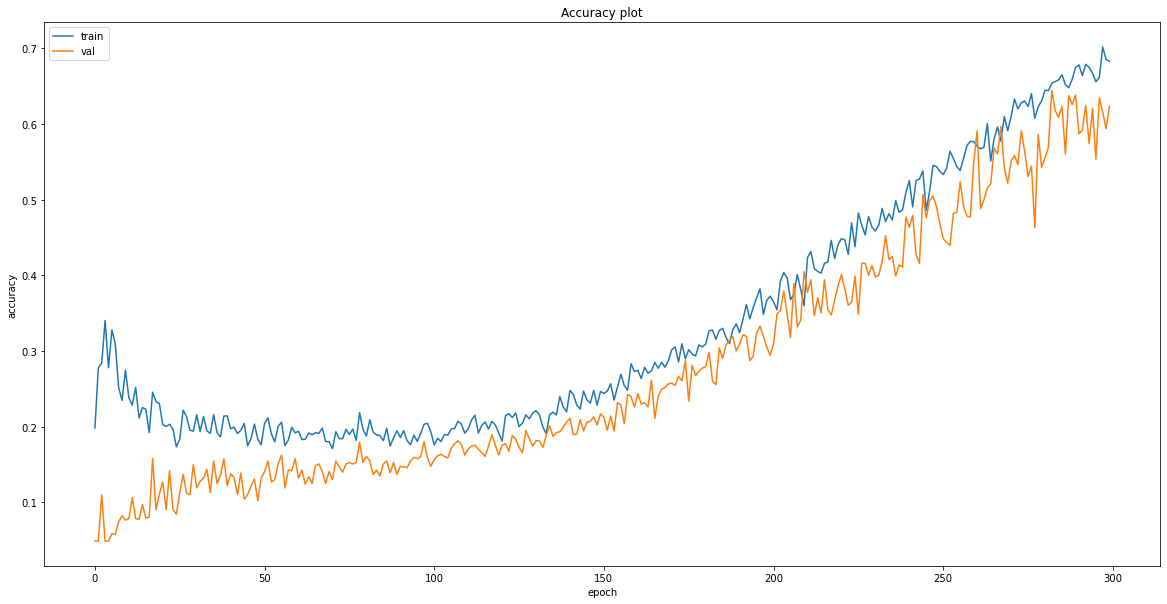

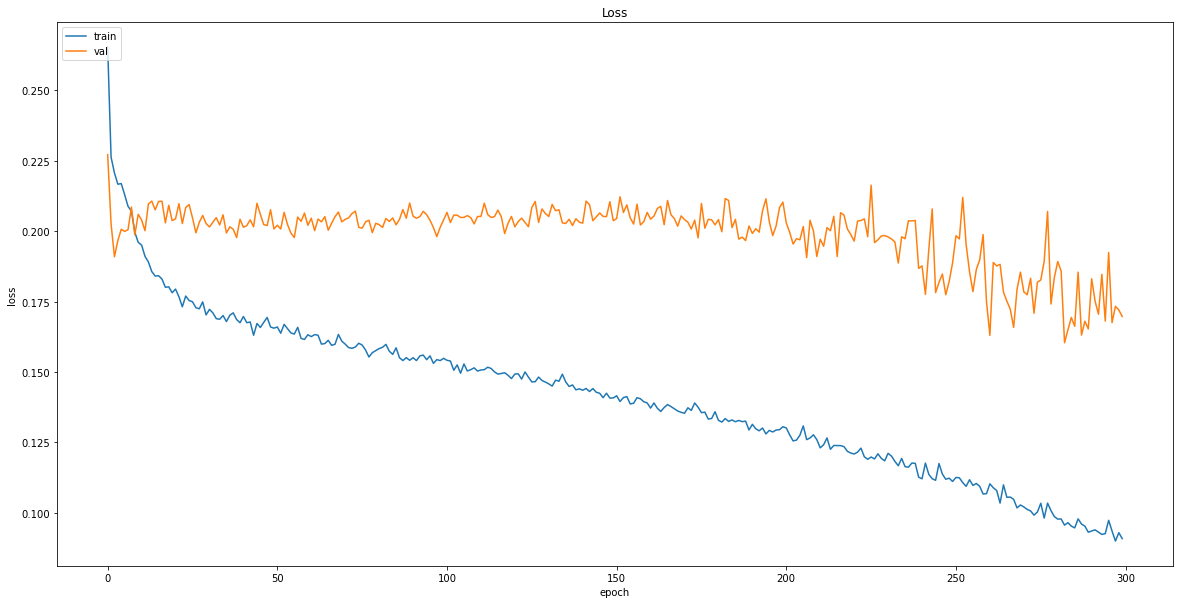

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Save model
model.save("models/{}".format('OCBC_time_series_cnn_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/OCBC_time_series_cnn_buy_hold_sell_original.model\assets


In [21]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/O39.SI_data_test.csv")
print(df.head())

         Date  previous_1d     EMA_7   willr_7     OBV_7  labels
0  2020-01-13     0.964602  0.956549  0.833332  0.941370     2.0
1  2020-01-14     0.958702  0.960911  0.777778  0.933340     2.0
2  2020-01-15     0.970502  0.967884  0.941178  0.944305     2.0
3  2020-01-16     0.935103  0.962010  0.588234  0.932643     2.0
4  2020-01-17     0.973451  0.969633  0.916665  0.975363     0.0


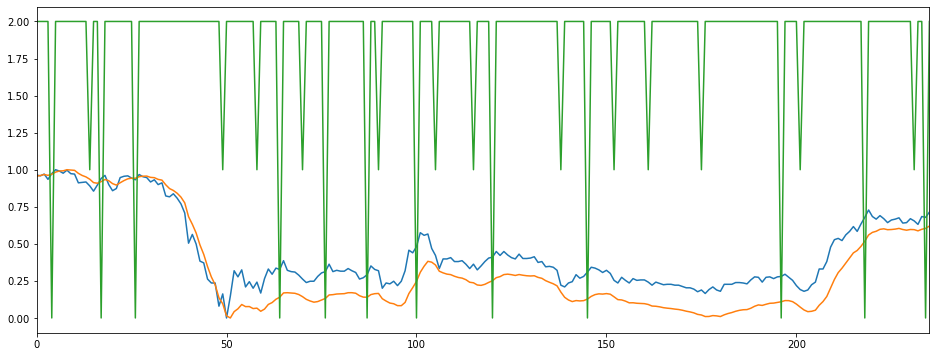

In [22]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [23]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels
Date,,,,,
2020-01-13,0.964602,0.956549,0.833332,0.941370,2.0
2020-01-14,0.958702,0.960911,0.777778,0.933340,2.0
2020-01-15,0.970502,0.967884,0.941178,0.944305,2.0
2020-01-16,0.935103,0.962010,0.588234,0.932643,2.0
2020-01-17,0.973451,0.969633,0.916665,0.975363,0.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        for j in range(1,114):
            x = np.zeros(128)
            data_15.append(x)
        labels.append(i[-1])
        sequential.append(data_15)
        data_15 = data_15[1:15]
    else:
        x = np.zeros(124)
        arr = np.concatenate((i[0:-1], x))
        data_15.append(arr)
        count+= 1

In [25]:
X = np.array(sequential).reshape(-1, 128, 128, 1)
y = labels
y = np.array(y)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/OCBC_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 16ms/step - loss: 0.2480 - accuracy: 0.5315
Test loss: 0.24801839888095856
Test accuracy: 0.5315315127372742


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 130, 1: 69, 0: 23})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [30]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/normalized/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_7   willr_7     OBV_7  labels
Date                                                         
2020-01-13     0.964602  0.956549  0.833332  0.941370     2.0
2020-01-14     0.958702  0.960911  0.777778  0.933340     2.0
2020-01-15     0.970502  0.967884  0.941178  0.944305     2.0
2020-01-16     0.935103  0.962010  0.588234  0.932643     2.0
2020-01-17     0.973451  0.969633  0.916665  0.975363     0.0


In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_7,willr_7,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-01-31,0.890855,0.951502,0.333333,0.973627,2.0,2,1
2020-02-03,0.855457,0.935844,0.170213,0.943061,1.0,1,2
2020-02-04,0.896755,0.912996,0.020409,0.917137,2.0,2,2
2020-02-05,0.941003,0.908815,0.365855,0.938036,2.0,2,0
2020-02-06,0.961652,0.919559,0.937499,0.952576,0.0,2,2


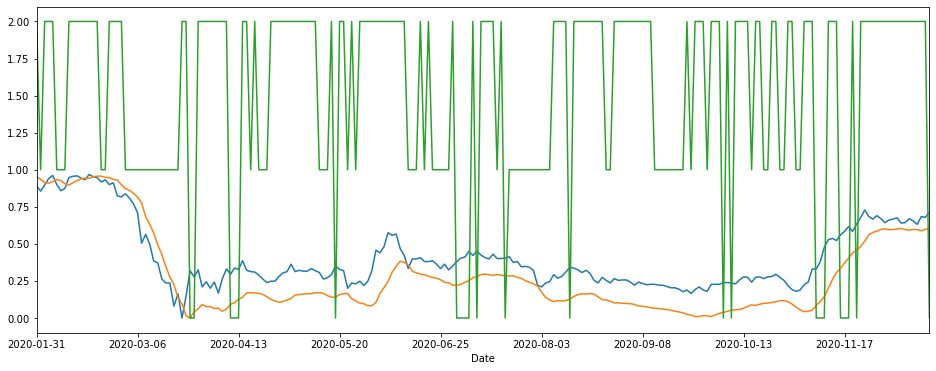

In [32]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_7'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

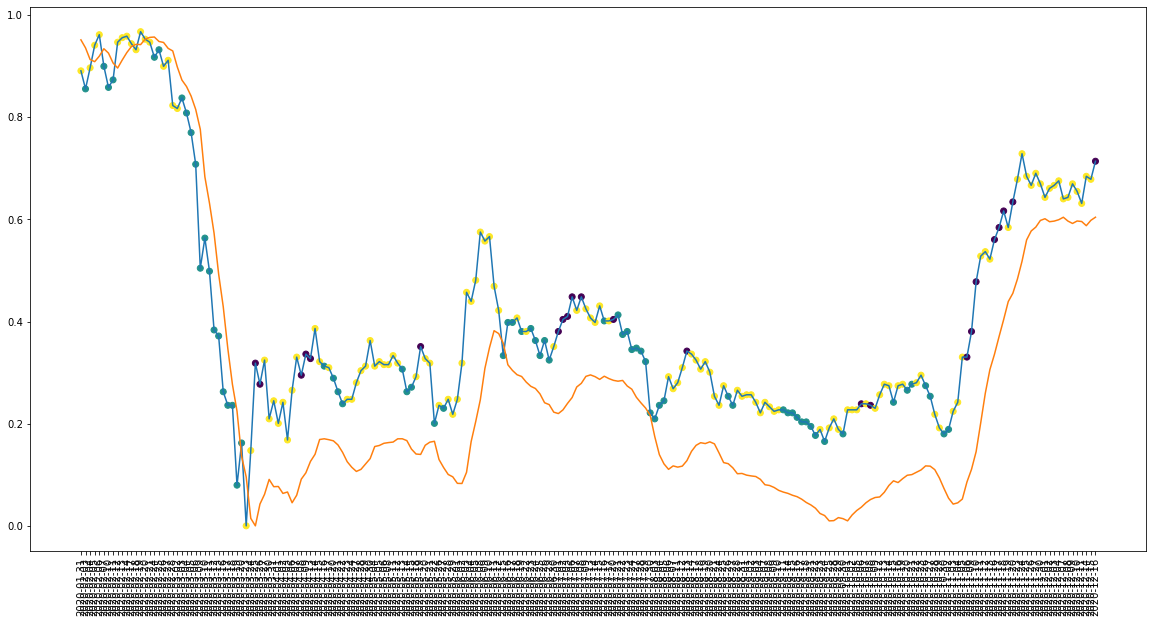

In [33]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_7'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [34]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 222
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 65
actual holds but predicted sell: 21
actual predicted holds: 112
Percentage buys correct: 30.76923076923077%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 56.56565656565657%
actual buys: 13
actual sells: 11
actual holds: 198
